# Upper Air Sounding Analysis

This notebook creates Skew-T Log-P diagrams from upper air sounding data accessed via REST API.

## Setup

First, let's install the required packages:

In [1]:
!pip install requests pandas numpy matplotlib metpy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Import Libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import (
    parcel_profile, 
    cape_cin, 
    lifted_index, 
    precipitable_water, 
    wind_components, 
    bulk_shear
)

## Define Functions

In [3]:
def fetch_sounding_data(report_id):
    """Fetch sounding data from the API"""
    url = f"http://65.21.25.17/collections/upper_air/items?report={report_id}&sortby=-z_value&f=json&limit=20000"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        data = response.json()
        features = data.get('features', [])        
        del features[0]
        rows = []
        for feature in features:
            props = feature.get('properties', {})
            geom = feature.get('geometry', {})
            coords = geom.get('coordinates', [0, 0])
            
            row = {
                'z_value': props.get('z_value'),
                'datetime': props.get('datetime'),
                'lon': coords[0],
                'lat': coords[1],
                'temperature': props.get('temperature'),
                'dew_point_temperature': props.get('dew_point_temperature'),
                'wind_speed': props.get('wind_speed'),
                'wind_direction': props.get('wind_direction')
            }
            rows.append(row)
        
        df = pd.DataFrame(rows)
        return df.sort_values('z_value', ascending=False)
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        raise

In [4]:
def create_skewt_plot(data):
    """Create Skew-T plot from DataFrame"""
    # assign units
    pressure = data['z_value'].values  * units.hPa
    temperature = data['temperature'].values  * units.degC
    dewpoint = data['dew_point_temperature'].values  * units.degC
    wind_speed = data['wind_speed'].values  * units.meter_per_second
    wind_dir = data['wind_direction'].values  * units.degrees
    
    # Calculate wind components
    u, v = wind_components(wind_speed, wind_dir)

    # Create figure and SkewT object
    fig = plt.figure(figsize=(15, 15))
    skew = SkewT(fig, rotation=45)

    # Plot temperature and dewpoint
    skew.plot(pressure, temperature, 'r', linewidth=2, label='Temperature')
    skew.plot(pressure, dewpoint, 'g', linewidth=2, label='Dew Point')

    # Add wind barbs
    skew.plot_barbs(pressure[::10], u[::10], v[::10])

    # Calculate and plot parcel profile
    prof = parcel_profile(pressure, temperature[0], dewpoint[0]).to('degC')
    skew.plot(pressure, prof, 'k', linewidth=1, linestyle='--', label='Parcel')

    # Add standard features
    skew.plot_dry_adiabats(alpha=0.4)
    skew.plot_moist_adiabats(alpha=0.4)
    skew.plot_mixing_lines(alpha=0.4)

    try:
        # Calculate stability indices
        cape, cin = cape_cin(pressure, temperature, dewpoint, prof)
        li, = lifted_index(pressure, temperature, prof)
        pwat = precipitable_water(pressure, dewpoint)
        # shr_6km = bulk_shear(pressure, u, v, depth=6000 * units.meter)

        # Add text box with calculated parameters
        info_txt = (
            f'CAPE: {cape.magnitude:0.01f} J/kg\n'
            f'CIN: {cin.magnitude:0.01f} J/kg\n'
            f'Lifted Index: {li.magnitude:0.01f}\n'
            f'Precipitable Water: {pwat.magnitude:0.01f} mm\n'
            #f'6km Shear: {shr_6km.magnitude:.1f} m/s\n'
            f'Location: {data["lat"].iloc[0]:.2f}°N, {data["lon"].iloc[0]:.2f}°E\n'
            f'Time: {data["datetime"].iloc[0]}'
        )

        plt.text(1.2, 0.95, info_txt, transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.7), fontsize=10,
                verticalalignment='top')

        # Shade CAPE and CIN areas
        skew.shade_cape(pressure, temperature, prof)
        skew.shade_cin(pressure, temperature, prof)
    except Exception as e:
        print(f"Warning: Could not calculate some stability indices: {e}")

    # Set limits and labels
    skew.ax.set_ylim(max(pressure.magnitude), min(pressure.magnitude))
    skew.ax.set_xlim(-40, 40)
    plt.title(f'Skew-T Log-P Diagram\nReport ID: {data["datetime"].iloc[0]}', fontsize=14)
    plt.legend(loc='upper right')
    skew.ax.grid(True, alpha=0.3)

    return fig

## Fetch and Plot Data

Now let's fetch the data and create the plot for a specific report ID:

In [5]:
# Set the report ID
report_id = 120367 

# Fetch the data
data = fetch_sounding_data(report_id)

# Display the first few rows of data
print("Raw data preview:")
display(data.head())

Raw data preview:


,z_value,datetime,lon,lat,temperature,dew_point_temperature,wind_speed,wind_direction
0,1001.8,2025-02-19T23:14:59+00:00,117.816334,-34.941360,18.77,17.04,3.9,67.0
1,1001.4,2025-02-19T23:15:01+00:00,117.816158,-34.941364,18.48,16.88,4.0,65.0
2,1000.4,2025-02-19T23:15:03+00:00,117.815984,-34.941360,18.38,16.71,4.5,64.0
3,1000.0,2025-02-19T23:15:04+00:00,117.815918,-34.941376,18.36,16.69,5.0,64.0
4,999.2,2025-02-19T23:15:05+00:00,117.815862,-34.941412,18.31,16.65,5.0,64.0


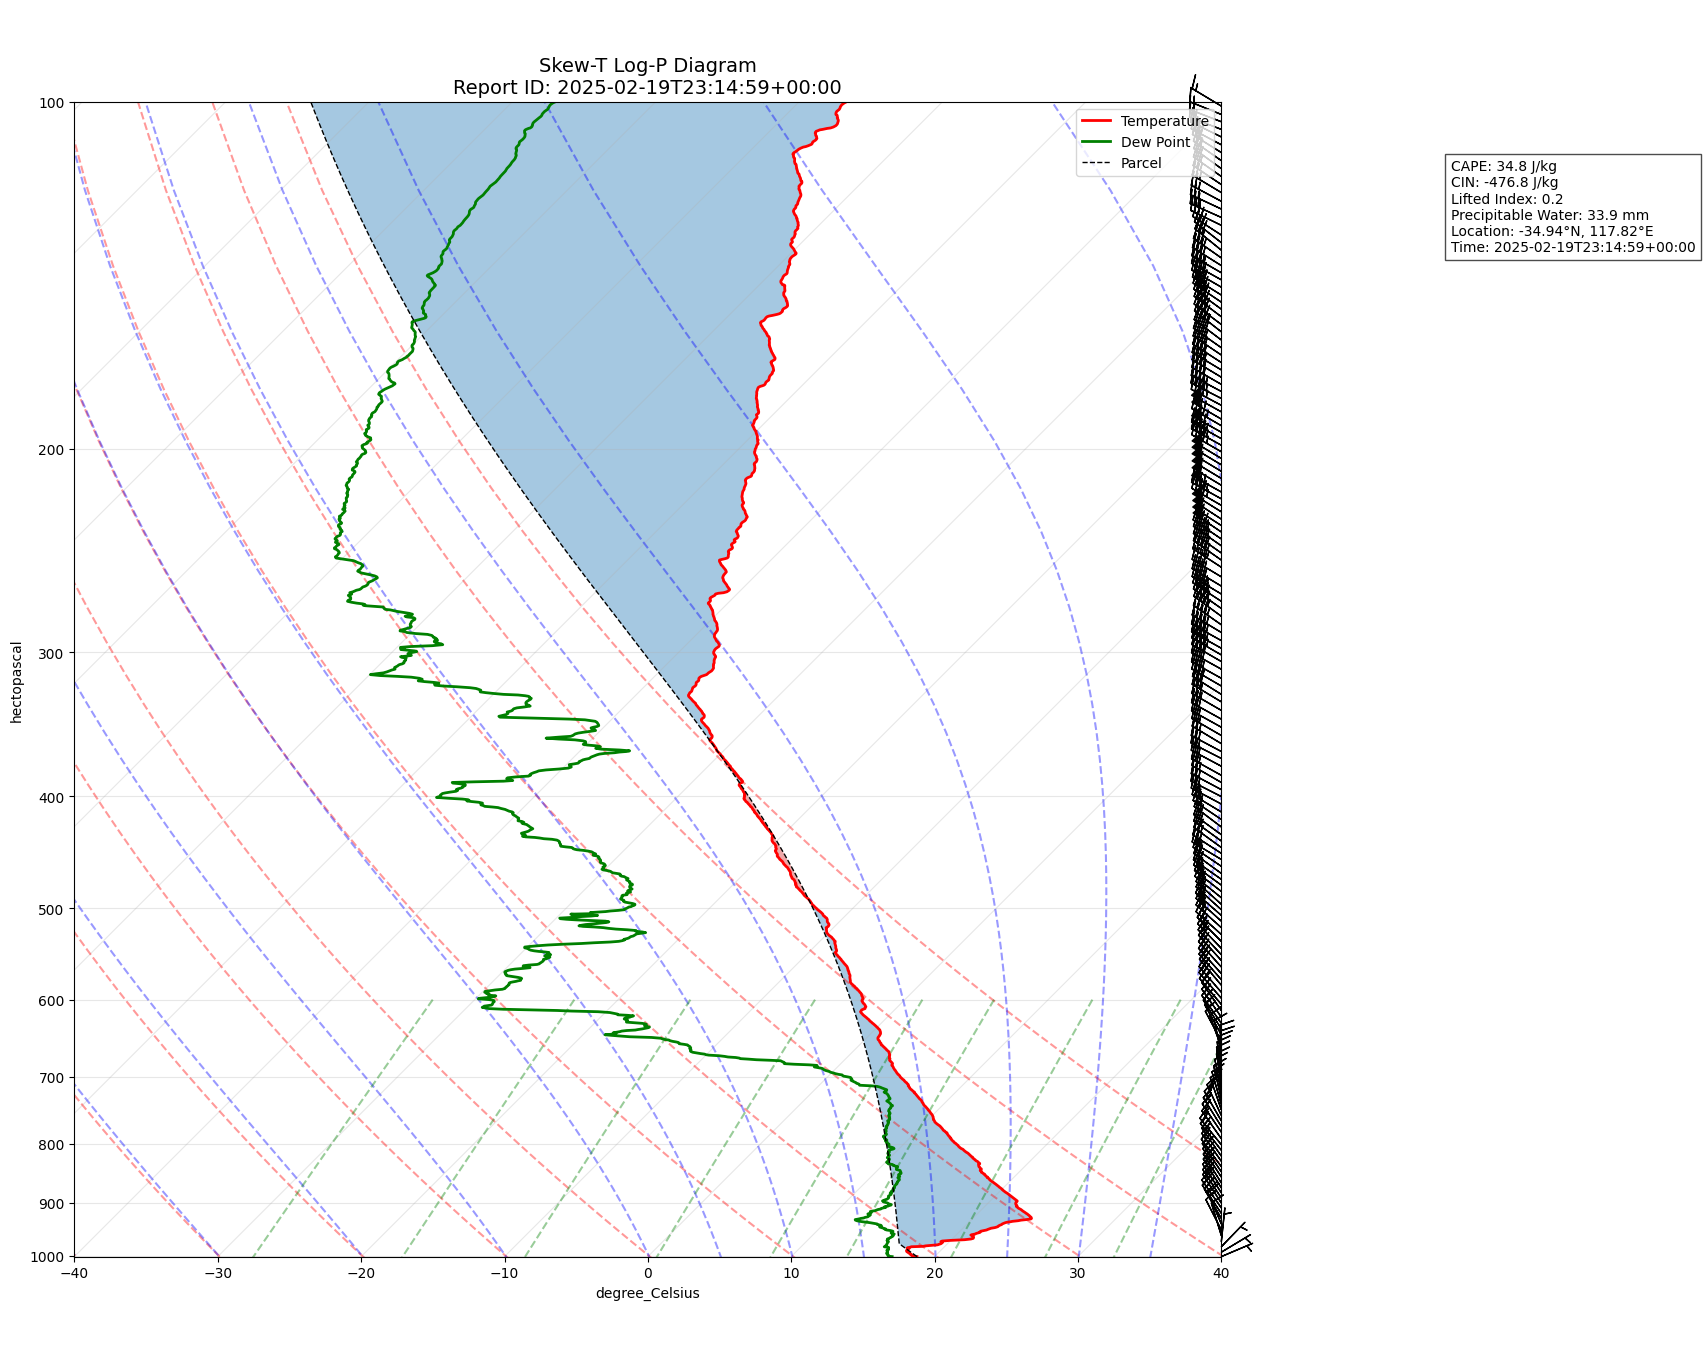

In [6]:
# Create and display the plot
fig = create_skewt_plot(data)
plt.show()

## Analysis Functions

Let's add some additional analysis functions to examine the data:

In [7]:
def analyze_sounding(data):
    """Perform basic analysis of the sounding data"""
    analysis = {
        'pressure_levels': len(data),
        'max_height': data['z_value'].min(),
        'surface_temp': data['temperature'].iloc[0],
        'surface_dewpoint': data['dew_point_temperature'].iloc[0],
        'max_wind': data['wind_speed'].max(),
        'temp_range': data['temperature'].max() - data['temperature'].min()
    }
    
    print("\nSounding Analysis:")
    print(f"Number of pressure levels: {analysis['pressure_levels']}")
    print(f"Maximum height (minimum pressure): {analysis['max_height']:.0f} hPa")
    print(f"Surface temperature: {analysis['surface_temp']:.1f}°C")
    print(f"Surface dewpoint: {analysis['surface_dewpoint']:.1f}°C")
    print(f"Maximum wind speed: {analysis['max_wind']:.1f} m/s")
    print(f"Temperature range: {analysis['temp_range']:.1f}°C")
    
    return analysis

In [8]:
# Run the analysis
analysis = analyze_sounding(data)


Sounding Analysis:
Number of pressure levels: 1697
Maximum height (minimum pressure): 100 hPa
Surface temperature: 18.8°C
Surface dewpoint: 17.0°C
Maximum wind speed: 49.0 m/s
Temperature range: 90.9°C
